In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')

import os
from os import listdir
from PIL import Image

from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from xgboost import XGBClassifier

2023-12-03 21:06:03.694929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install opencv-python

In [2]:
carrigan = False

### Load Data

In [3]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [4]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [5]:
newsize = (256, 256)

In [6]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [7]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [8]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [11]:
imgs

,image_id,image
0,Cyst- (630),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Cyst- (260),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Cyst- (1631),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Cyst- (1261),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Cyst- (1774),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
12441,Tumor- (209),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12442,Tumor- (1390),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12443,Tumor- (659),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12444,Tumor- (1685),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [12]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [13]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [14]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [15]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [17]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

(12446, 256, 256)
(12446, 65536)


In [18]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

(12446, 65537)


In [20]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

(11929, 65537)


In [21]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

(11929, 65536)
(11929, 1)


### Perform SMOTE

In [22]:
# Divide by 255, keep as float32 data
#print(np.max(X))
#X = (X.astype(np.float32) / 255.0).astype(np.float32)
#print(np.max(X))

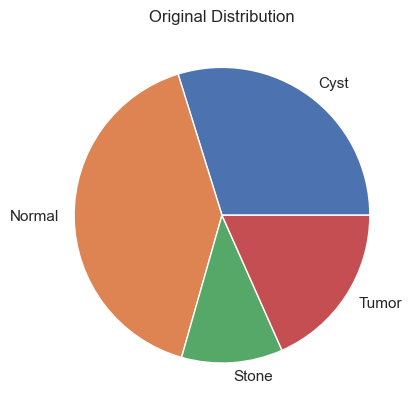

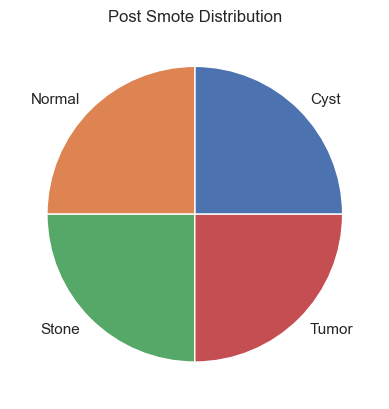

In [19]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [10]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [20]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

(20308, 65536)


In [12]:
del Xsmote
del ysmote

### Train and test split

In [21]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [22]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [23]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [16]:
del Xshuffled
del yshuffled

### Image Augmentation

In [ ]:
# Create augmentation layers
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ],
)

In [ ]:
example_image = X_train[2]
print(example_image.shape)


(256, 256, 1)


In [ ]:
# def rotate_image(image):
#     # Random angle between -20 and 20 degrees
#     angle = np.random.uniform(-20, 20)
#     rotated_image = np.interp(np.arange(len(image)), np.arange(len(image)) + angle, image, left=0, right=0)
#     return rotated_image

# def zoom_image(image):
#     # Random zoom factor between 0.8 and 1.2
#     zoom_factor = np.random.uniform(0.8, 1.2)
#     zoomed_image = np.interp(np.arange(len(image)), np.arange(len(image)) * zoom_factor, image, left=0, right=0)
#     return zoomed_image

# def flip_image(image):
#     # Randomly flip the image horizontally
#     if np.random.rand() > 0.5:
#         flipped_image = np.flip(image)
#     else:
#         flipped_image = image
#     return flipped_image

# def augment_image(image):
#     # Apply rotation
#     rotated_image = rotate_image(image)

#     # Apply zoom
#     zoomed_image = zoom_image(rotated_image)

#     # Apply flip
#     flipped_image = flip_image(zoomed_image)

#     return flipped_image

# # Perform image augmentation on the training data
# X_train_augmented = [augment_image(image) for image in X_train]

# # Convert the augmented data back to NumPy array
# X_train_augmented = np.array(X_train_augmented)

# # Concatenate the original and augmented data
# X_train_combined = np.concatenate((X_train, X_train_augmented))
# y_train_combined = np.concatenate((y_train, y_train.copy()))

# # Ensure X_train_combined and y_train_combined have the correct shapes
# print(X_train_combined.shape)
# print(y_train_combined.shape)



In [ ]:
# X_train = X_train_combined
# y_train = y_train_combined

In [ ]:
# X_train = np.stack(X_train, axis=0)
# Y_train = np.stack(y_train, axis=0)
# X_test = np.stack(X_test, axis=0)
# Y_test = np.stack(y_test, axis=0)

# Create Models

### Model 1 - Multiclass Classifier

In [ ]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.01)

history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=5,
  batch_size=128,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
27/27 [==============================] - 5s 27ms/step - loss: 4.6771 - accuracy: 0.3353 - val_loss: 5.6589 - val_accuracy: 0.2553
Epoch 2/5
27/27 [==============================] - 0s 16ms/step - loss: 2.7822 - accuracy: 0.5073 - val_loss: 1.2382 - val_accuracy: 0.5658
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 1.4026 - accuracy: 0.6793 - val_loss: 0.6226 - val_accuracy: 0.7605
Epoch 4/5
27/27 [==============================] - 0s 16ms/step - loss: 0.9967 - accuracy: 0.7461 - val_loss: 0.6415 - val_accuracy: 0.7474
Epoch 5/5
27/27 [==============================] - 0s 15ms/step - loss: 0.7319 - accuracy: 0.7855 - val_loss: 0.2425 - val_accuracy: 0.9368


,loss,accuracy,val_loss,val_accuracy
0,4.677085,0.335284,5.658864,0.255263
1,2.782225,0.507314,1.238211,0.565789
2,1.402648,0.679345,0.622620,0.760526
3,0.996723,0.746050,0.641527,0.747368
4,0.731937,0.785547,0.242497,0.936842


In [ ]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)
print(test_predictions)

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 2 - Neural Network

In [ ]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


Epoch 1/5
172/172 [==============================] - 5s 27ms/step - loss: 1321804.1250 - accuracy: 0.2567 - val_loss: 1.3841 - val_accuracy: 0.2551
Epoch 2/5
172/172 [==============================] - 4s 26ms/step - loss: 1.4063 - accuracy: 0.2497 - val_loss: 1.3839 - val_accuracy: 0.2559
Epoch 3/5
172/172 [==============================] - 5s 27ms/step - loss: 1.4061 - accuracy: 0.2560 - val_loss: 1.3865 - val_accuracy: 0.2535
Epoch 4/5
172/172 [==============================] - 4s 26ms/step - loss: 1.3851 - accuracy: 0.2505 - val_loss: 1.3864 - val_accuracy: 0.2535
Epoch 5/5
172/172 [==============================] - 4s 26ms/step - loss: 1.3851 - accuracy: 0.2445 - val_loss: 1.3864 - val_accuracy: 0.2535
127/127 - 1s - loss: 1.3848 - accuracy: 0.2386 - 634ms/epoch - 5ms/step


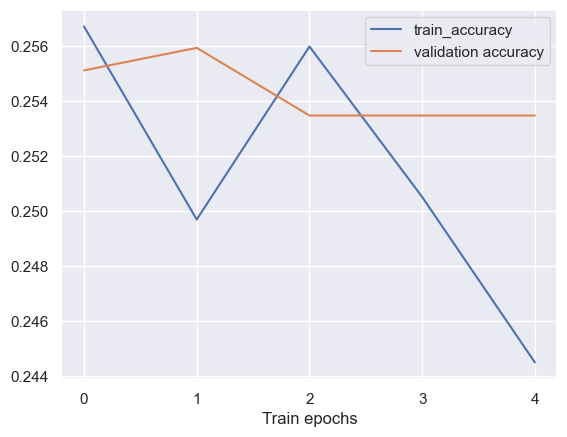

In [ ]:
# Build and compile the model
model2_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='SGD', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_sgd.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()


Epoch 1/5
172/172 [==============================] - 6s 35ms/step - loss: 3675.2935 - accuracy: 0.3979 - val_loss: 1.2665 - val_accuracy: 0.3396
Epoch 2/5
172/172 [==============================] - 6s 35ms/step - loss: 49.6771 - accuracy: 0.3437 - val_loss: 1.2673 - val_accuracy: 0.3339
Epoch 3/5
172/172 [==============================] - 6s 35ms/step - loss: 16.9213 - accuracy: 0.3240 - val_loss: 1.3553 - val_accuracy: 0.2633
Epoch 4/5
172/172 [==============================] - 6s 35ms/step - loss: 1.6801 - accuracy: 0.2880 - val_loss: 1.3129 - val_accuracy: 0.2871
Epoch 5/5
172/172 [==============================] - 6s 36ms/step - loss: 1.3257 - accuracy: 0.2910 - val_loss: 1.3111 - val_accuracy: 0.3043
127/127 - 1s - loss: 1.3249 - accuracy: 0.2804 - 638ms/epoch - 5ms/step


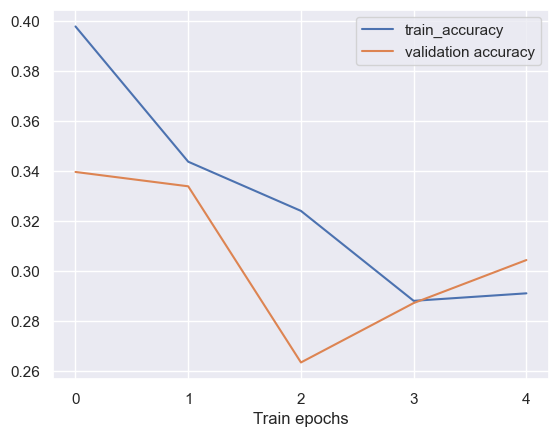

In [ ]:
model2_rms = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='RMSprop', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_rms.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_rms.evaluate(X_val_flat, y_val, verbose=2)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

Epoch 1/5
172/172 [==============================] - 7s 40ms/step - loss: 2611.5374 - accuracy: 0.7083 - val_loss: 2.7581 - val_accuracy: 0.6907
Epoch 2/5
172/172 [==============================] - 7s 41ms/step - loss: 1.0303 - accuracy: 0.6751 - val_loss: 0.6800 - val_accuracy: 0.6891
Epoch 3/5
172/172 [==============================] - 7s 40ms/step - loss: 0.7066 - accuracy: 0.6886 - val_loss: 0.7123 - val_accuracy: 0.7039
Epoch 4/5
172/172 [==============================] - 7s 39ms/step - loss: 0.6463 - accuracy: 0.7077 - val_loss: 0.6405 - val_accuracy: 0.7129
Epoch 5/5
172/172 [==============================] - 7s 39ms/step - loss: 0.6292 - accuracy: 0.7134 - val_loss: 0.5933 - val_accuracy: 0.7244
127/127 - 1s - loss: 0.6342 - accuracy: 0.7019 - 622ms/epoch - 5ms/step


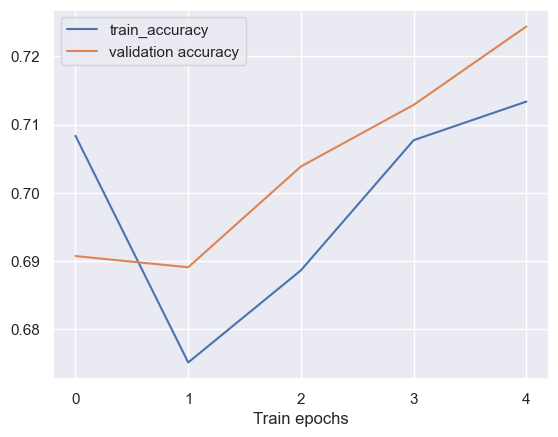

In [ ]:
model2_adam = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_adam.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_adam.evaluate(X_val_flat, y_val, verbose=2)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

### Models 3-4 - CNN

In [27]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [28]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [29]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
X_train_reshaped = X_train_reshaped / 255.0
X_val_reshaped = X_val_reshaped / 255.0
X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


2023-12-03 21:10:30.318849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [ ]:
# Train the CNN model for 5 epochs
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 4s 20ms/step - loss: 1.3553 - accuracy: 0.3598 - val_loss: 1.3158 - val_accuracy: 0.4651
Epoch 2/10
172/172 [==============================] - 3s 19ms/step - loss: 1.2425 - accuracy: 0.5123 - val_loss: 1.1480 - val_accuracy: 0.5316
Epoch 3/10
172/172 [==============================] - 3s 19ms/step - loss: 1.0995 - accuracy: 0.5448 - val_loss: 1.0421 - val_accuracy: 0.5332
Epoch 4/10
172/172 [==============================] - 3s 19ms/step - loss: 1.0359 - accuracy: 0.5691 - val_loss: 1.0192 - val_accuracy: 0.5915
Epoch 5/10
172/172 [==============================] - 3s 19ms/step - loss: 0.9875 - accuracy: 0.5936 - val_loss: 0.8818 - val_accuracy: 0.6497
Epoch 6/10
172/172 [==============================] - 3s 19ms/step - loss: 0.9078 - accuracy: 0.6390 - val_loss: 0.9002 - val_accuracy: 0.6530
Epoch 7/10
172/172 [==============================] - 4s 21ms/step - loss: 0.8573 - accuracy: 0.6660 - val_loss: 0.7905 - val_accuracy: 0.6784

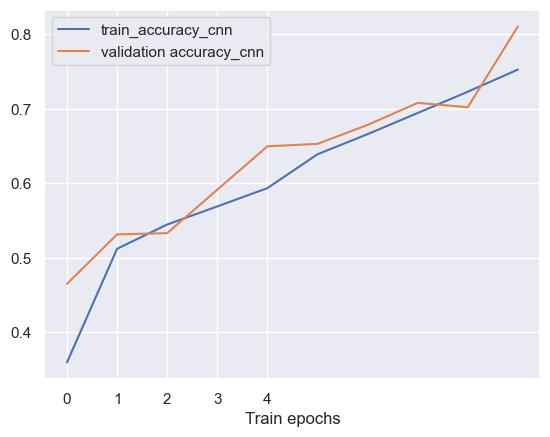

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 4s 19ms/step - loss: 1.0215 - accuracy: 0.5399 - val_loss: 0.5690 - val_accuracy: 0.8039
Epoch 2/10
172/172 [==============================] - 3s 19ms/step - loss: 0.4443 - accuracy: 0.8337 - val_loss: 0.3484 - val_accuracy: 0.8769
Epoch 3/10
172/172 [==============================] - 3s 18ms/step - loss: 0.2812 - accuracy: 0.8951 - val_loss: 0.2731 - val_accuracy: 0.8991
Epoch 4/10
172/172 [==============================] - 3s 18ms/step - loss: 0.2203 - accuracy: 0.9202 - val_loss: 0.2015 - val_accuracy: 0.9237
Epoch 5/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1633 - accuracy: 0.9415 - val_loss: 0.2503 - val_accuracy: 0.9073
Epoch 6/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1330 - accuracy: 0.9525 - val_loss: 0.1367 - val_accuracy: 0.9524
Epoch 7/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1346 - accuracy: 0.9523 - val_loss: 0.1928 - val_accuracy: 0.9368

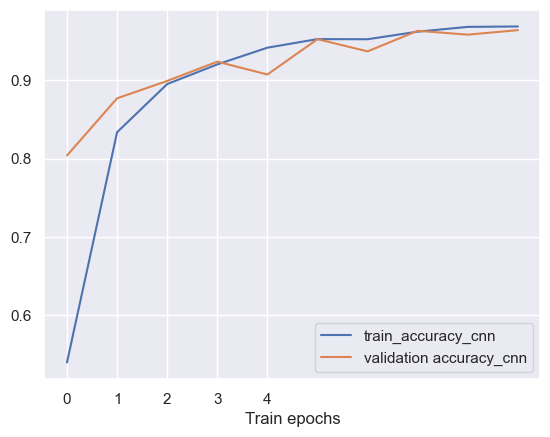

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 4s 19ms/step - loss: 1.3653 - accuracy: 0.3870 - val_loss: 0.9133 - val_accuracy: 0.6112
Epoch 2/10
172/172 [==============================] - 3s 18ms/step - loss: 0.6160 - accuracy: 0.7552 - val_loss: 0.2692 - val_accuracy: 0.9048
Epoch 3/10
172/172 [==============================] - 3s 18ms/step - loss: 0.2442 - accuracy: 0.9111 - val_loss: 0.4569 - val_accuracy: 0.8491
Epoch 4/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1643 - accuracy: 0.9465 - val_loss: 0.1444 - val_accuracy: 0.9418
Epoch 5/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1208 - accuracy: 0.9658 - val_loss: 0.0924 - val_accuracy: 0.9737
Epoch 6/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0982 - accuracy: 0.9705 - val_loss: 0.0775 - val_accuracy: 0.9737
Epoch 7/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0892 - accuracy: 0.9766 - val_loss: 0.1225 - val_accuracy: 0.9672

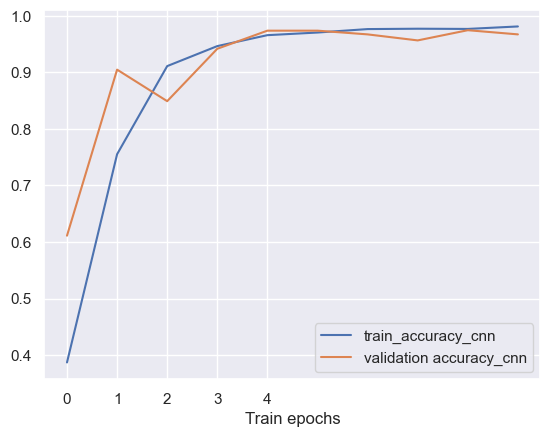

In [ ]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [25]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [31]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 10s 56ms/step - loss: 2.5059 - accuracy: 0.2501 - val_loss: 1.3863 - val_accuracy: 0.2535
Epoch 2/10
172/172 [==============================] - 9s 55ms/step - loss: 1.3872 - accuracy: 0.2538 - val_loss: 1.3858 - val_accuracy: 0.2568
Epoch 3/10
172/172 [==============================] - 10s 55ms/step - loss: 1.3868 - accuracy: 0.2546 - val_loss: 1.3880 - val_accuracy: 0.2338
Epoch 4/10
172/172 [==============================] - 10s 55ms/step - loss: 1.3870 - accuracy: 0.2548 - val_loss: 1.3866 - val_accuracy: 0.2338
Epoch 5/10
172/172 [==============================] - 10s 55ms/step - loss: 1.3871 - accuracy: 0.2393 - val_loss: 1.3867 - val_accuracy: 0.2535
Epoch 6/10
172/172 [==============================] - 10s 56ms/step - loss: 1.3867 - accuracy: 0.2570 - val_loss: 1.3884 - val_accuracy: 0.2338
Epoch 7/10
172/172 [==============================] - 10s 56ms/step - loss: 1.3870 - accuracy: 0.2448 - val_loss: 1.3866 - val_accuracy: 

In [32]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 10s 56ms/step - loss: 1.3787 - accuracy: 0.2734 - val_loss: 1.3619 - val_accuracy: 0.4110
Epoch 2/10
172/172 [==============================] - 10s 55ms/step - loss: 1.3504 - accuracy: 0.3413 - val_loss: 1.3118 - val_accuracy: 0.5693
Epoch 3/10
172/172 [==============================] - 10s 56ms/step - loss: 1.2799 - accuracy: 0.4346 - val_loss: 1.1812 - val_accuracy: 0.5168
Epoch 4/10
172/172 [==============================] - 10s 56ms/step - loss: 1.1798 - accuracy: 0.4780 - val_loss: 1.1486 - val_accuracy: 0.5086
Epoch 5/10
172/172 [==============================] - 10s 56ms/step - loss: 1.1219 - accuracy: 0.5144 - val_loss: 1.0154 - val_accuracy: 0.5775
Epoch 6/10
172/172 [==============================] - 10s 56ms/step - loss: 1.0778 - accuracy: 0.5421 - val_loss: 1.1488 - val_accuracy: 0.4725
Epoch 7/10
172/172 [==============================] - 10s 56ms/step - loss: 1.0267 - accuracy: 0.5810 - val_loss: 0.9106 - val_accuracy:

In [33]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 10s 56ms/step - loss: 1.3828 - accuracy: 0.3230 - val_loss: 1.1284 - val_accuracy: 0.4463
Epoch 2/10
172/172 [==============================] - 10s 55ms/step - loss: 1.1664 - accuracy: 0.4416 - val_loss: 1.0665 - val_accuracy: 0.5021
Epoch 3/10
172/172 [==============================] - 10s 55ms/step - loss: 1.1189 - accuracy: 0.4800 - val_loss: 1.0117 - val_accuracy: 0.5480
Epoch 4/10
172/172 [==============================] - 10s 55ms/step - loss: 1.0535 - accuracy: 0.5231 - val_loss: 0.9342 - val_accuracy: 0.5472
Epoch 5/10
172/172 [==============================] - 10s 55ms/step - loss: 0.9863 - accuracy: 0.5481 - val_loss: 0.8684 - val_accuracy: 0.6341
Epoch 6/10
172/172 [==============================] - 10s 56ms/step - loss: 0.9301 - accuracy: 0.5887 - val_loss: 0.8471 - val_accuracy: 0.6686
Epoch 7/10
172/172 [==============================] - 10s 56ms/step - loss: 0.9153 - accuracy: 0.6002 - val_loss: 0.7838 - val_accuracy:

### Test CNN Model and Create ROC Curve

In [ ]:
predictions = cnn_model.predict(X_test_rgb)
class_predictions = np.argmax(predictions, axis=-1)
print(class_predictions)

127/127 [==============================] - 1s 4ms/step
[3 3 3 ... 3 3 3]


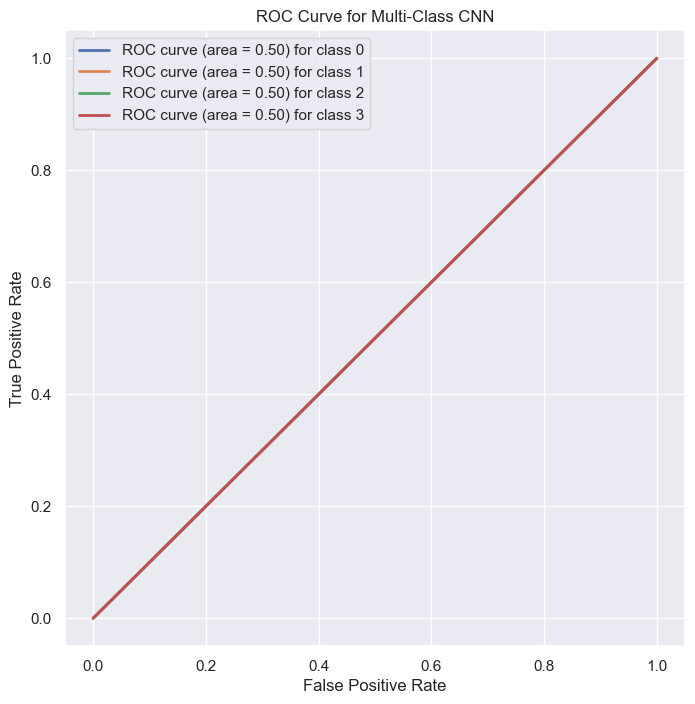

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN')
plt.legend()
plt.show()

### Model 5 - Transfer Learning

In [ ]:
# Should have shape (12184, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape)

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model4 = keras.Model(inputs, outputs)

model4.summary()

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model4.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, validation_data = (X_val_3_channel, y_val))

### Model 6 - KNN

In [ ]:
model5 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
model5.fit(X_train_flat, y_train)

KNeighborsClassifier(n_neighbors=70)

In [ ]:
y_pred = model5.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

error: 0.061219390304847576
Val prediction accuracy: 0.939


In [ ]:
y_pred = model5.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

error: 0.06271864067966017
Test prediction accuracy: 0.937


### Model 7 - Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display

In [ ]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dt.fit(X_train_flat, y_train)
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))

Val accuracy: 0.9753815854258986
Test accuracy: 0.9761201378631216


NameError: ignored

Output: /content/iris-decisiontree.jpg


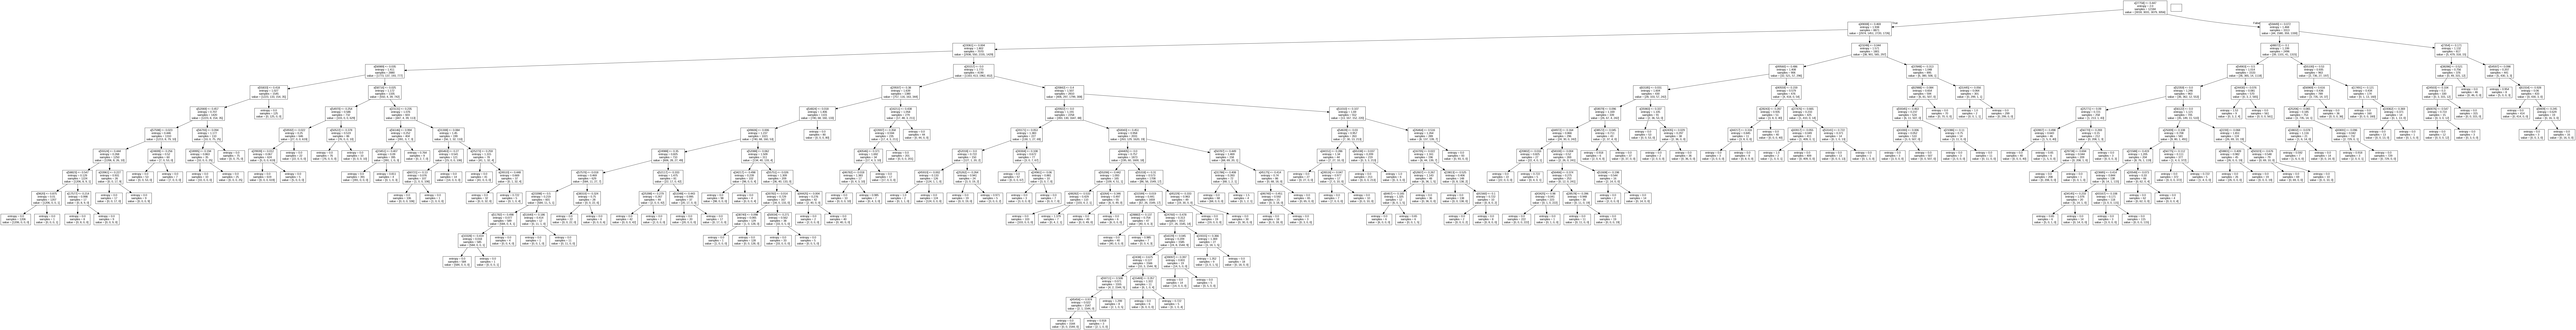

In [ ]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

### Model 8 - Random Forest

In [ ]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [ ]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = rf_classifier.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Random Forest Classifier Accuracy: 0.9955686853766618


### Model 9 - XGBoost

In [18]:
model9 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
model9.fit(X_train_flat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=50,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
y_pred = model9.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

error: 0.012243878060969516
Val prediction accuracy: 0.988


In [22]:
y_pred = model9.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

error: 0.011494252873563218
Test prediction accuracy: 0.989
